# Single Harmonic
This looks at how much information can be extracted about the seasonal cycle, restricting ourselves to a single harmonic.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, gamma_linear_approx, swdn_from_temp_fourier, get_temp_exact
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']
# Load dataset

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = ["k=1"]

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['evap=0_1']


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
lat_range = slice(30, 60)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = (ds_use.lwdn_sfc/Stefan_Boltzmann)**0.25/ds_use.t_surf
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]

is_wishe=True
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
    if w_atm_const > 0:
        is_wishe=False
        for i in range(n_exp):
            # Set wind to the constant value if it is set in namelist
            ds_base[i]['w_atm'] = ds_base[i]['w_atm']*0+w_atm_const
except KeyError:
    w_atm_const = np.nan

try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1

  0%|          | 0/1 [00:00<?, ?it/s]

Removing height from var_keep


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
def get_annual_zonal_mean(ds):
    ds_av = annual_mean(ds).mean(dim='lon')
    ds_av = ds_av.assign_coords(time=(ds_av.time - ds_av.time.min()).astype(int))
    return ds_av

In [5]:
ds = get_annual_zonal_mean(ds_base[0])
p_surface = float(ds.pfull)*100
if isinstance(w_atm_const, (int, float)):
    if w_atm_const == 0 or w_atm_const == np.nan:
        w_atm_const = ds.w_atm.mean(dim='time')

In [6]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
n_time = ds.time.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_anom = t_surf - np.mean(t_surf, axis=1)[:, np.newaxis]

## Obtaining Estimate of Amplitude and Phase of Actual Temperature Profile
Below, I smooth the temperature profile with a window of 20 days, and take the phase and amplitude of extrema from the resultant smoothed profile. These are indicated by the grey vertical lines, and differ slightly from the actual maxima and minima shown by the black solid lines.

I record the phase, as indicated by $\delta$, relative to the 1st harmonic of the insolation (shown by thick grey lines on left).

Below the example for a specific latitude, I plot the phase, $\delta$, and amplitude, $|T|$ for all latitudes. These are the values which we want to replicate, with a theoretical value.

In [7]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
for key in sw_amp_coefs:
    for i in range(n_lat):
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds.time, ds.swdn_sfc[:, i], n_time, int(key.replace('_harmonic', '')))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds.time, n_time, sw_amp_coefs[key][i], np.zeros(int(key.replace('_harmonic', ''))))
        temp_anom_fourier_fit[key][i] = fourier.get_fourier_fit(ds.time, t_surf_anom[i], n_time, int(key.replace('_harmonic', '')))[0]
    temp_anom_fourier_fit[key] = temp_anom_fourier_fit[key] - np.mean(temp_anom_fourier_fit[key], axis=1)[:, np.newaxis]
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size/2)])}
time_extrema_temp = {key: {'simulated': np.zeros(n_lat), '1_harmonic': np.zeros(n_lat)} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros(n_lat), '1_harmonic': np.zeros(n_lat)} for key in ['min', 'max']}

smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day
for i in range(n_lat):
    for key in time_extrema_temp:
        for key2 in time_extrema_temp['min']:
            var_use, spline_use = get_var_extrema_date(ds.time, t_surf_anom[i] if key2=='simulated' else temp_anom_fourier_fit['1_harmonic'][i], 
                                                       smooth_window=smooth_ndays_temp_extrema, type=key, max_extrema=1)
            time_extrema_temp[key][key2][i] = var_use[0]
            amp_extrema_temp[key][key2][i] = np.abs(spline_use(time_extrema_temp[key][key2][i]))

In [17]:
# General plotting info
plot_lat_ind = -1
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds.time[0]-1, ds.time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), np.ceil(ds.lat[-1])]
color_approx = {'linear': default_colors[0], 'quartic': default_colors[3], 'quartic_1_harmonic': default_colors[3], '1_harmonic': 'k',
                'lw': default_colors[3], 'lh': default_colors[1], 'sh': default_colors[2], 'square': default_colors[1], 
                'square_phase': default_colors[1], 'linear_phase': default_colors[0]}
color_extrema = {'max': default_colors[3], 'min': default_colors[0]}
linestyle_approx = {'linear': '-', '1_harmonic': ':', 'square': ':', 'linear_phase': '--', 'square_phase': '-.', 
                    'linear_phase_0': '-', 'square_0': '-'}
color_harmonic = {'1_harmonic': default_colors[0], '2_harmonic': default_colors[1], '5_harmonic': default_colors[3]}
# approx 2 is for when square and linear different colors
linestyle_approx2 = {key: linestyle_approx[key] for key in ['1_harmonic', 'linear', 'linear_phase', 'square', 'square_phase']}
linestyle_approx2['square'] = '-'
linestyle_approx2['square_phase'] = '--'
linestyle_approx2['linear_phase'] = '--'

# Define error func to use
error_func_dict = {'max': lambda x, x_approx, norm=True, axis=1: np.max(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'median': lambda x, x_approx, norm=True, axis=1: np.median(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'mean': lambda x, x_approx, norm=True, axis=1: np.mean(np.abs(x - x_approx), axis=axis) / 
                                                                  (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1)}
error_func_use = 'mean'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

In [18]:
fig_sw_temp_sl, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.swdn_sfc[:, plot_lat_ind], color='k', label='Simulated')

ax[1].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_sw[key], ds.swdn_sfc.sel(time=time_extrema_sw[key])[plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    ax[1].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$SW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
fig_sw_temp_sl.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days", fontsize=8, y=0.93)
plt.close()

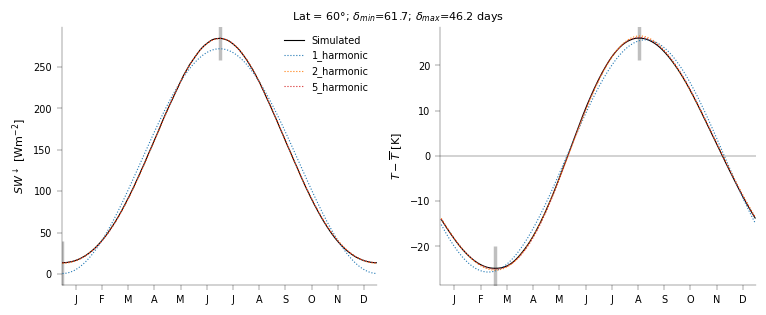

In [19]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
for key in sw_fourier_fit:
    ax[0].plot(ds.time, sw_fourier_fit[key][plot_lat_ind], color=color_harmonic[key], linestyle=linestyle_approx['1_harmonic'], label=key)
    ax[1].plot(ds.time, temp_anom_fourier_fit[key][plot_lat_ind], 
               color=color_harmonic[key], linestyle=linestyle_approx['1_harmonic'])
    ax[0].legend()
fig

In [39]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
gamma = {'simulated':np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose(), 
         'linear': np.zeros((n_lat, n_time))}
gamma_params = {'linear': np.zeros((n_lat, 2))}      # lowest power is last


temp_anom_linear_harmonics = {key: np.zeros((n_lat, n_time)) for key in sw_fourier_fit}
for i in range(n_lat):
    gamma_params['linear'][i] = np.polyfit(t_surf_anom[i], gamma['simulated'][i], 1)
    gamma['linear'][i] = numerical.apply_polyfit(t_surf_anom[i], gamma_params['linear'][i])
    for key in temp_anom_linear_harmonics:
        temp_anom_linear_harmonics[key][i] = get_temp_fourier_analytic(ds.time, ds.swdn_sfc.isel(lat=i), heat_capacity, gamma_params['linear'][i][0], 
                                                                  n_harmonics_sw=int(key.replace('_harmonic', '')))[0]


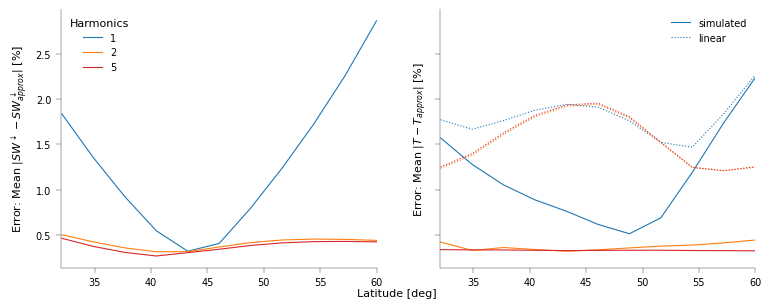

In [45]:
fig_error_sw, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
for key in sw_fourier_fit:
    ax[0].plot(ds.lat, error_func(smooth_func(ds.swdn_sfc.transpose().to_numpy()), sw_fourier_fit[key]), color=color_harmonic[key],
               label=key.replace('_harmonic', ''))
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_fourier_fit[key]), color=color_harmonic[key],
               label='simulated' if '1' in key else None)
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_linear_harmonics[key]), color=color_harmonic[key],
               label='linear' if '1' in key else None, linestyle=':')
    
ax[0].legend(title='Harmonics')
ax[1].legend()
ax[0].set_ylabel('$SW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$T - \overline{T}$ [K]')
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|SW^{\\downarrow} - SW^{\\downarrow}_{approx}|$ [%]')
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [%]')
ax[0].set_xlim(ax_lims_lat)
fig_error_sw.supxlabel('Latitude [deg]', fontsize=8, y=0.02);

In [29]:
fig_extrema, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    ax[0, i].plot(ds.lat, time_extrema_temp[key]['simulated'] - time_extrema_sw[key], color='k', label='Simulated')
    ax[1, i].plot(ds.lat, amp_extrema_temp[key]['simulated'], color='k')
    ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
    ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
fig_extrema.supxlabel('Latitude [deg]', fontsize=8, y=0.05)
plt.close()

## Best Possible Estimate from just single harmonic

The surface energy budget is 
$$
C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}
= SW^{\downarrow} - \Gamma^{\downarrow}
$$

Later we seek the best possible solution with a single harmonic, by replacing $SW^{\downarrow}$ with the annual harmonic, but keeping the exact form of $\Gamma^{\downarrow}$. THis is done by fitting a spline to $SW^{\downarrow} - \Gamma^{\downarrow}$ before integrating.

The plot clearly indicates that at latitudes lower than $60\degree$, additional harmonics of $SW^{\downarrow}$ are required, but at lower latitudes one will suffice.

In [30]:
gamma = {'simulated':np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose()}
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
temp_approx = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic']}

for key in time_extrema_temp:
    for key2 in ['1_harmonic']:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
for i in tqdm(range(n_lat)):
    for key in ['1_harmonic']:
        temp_approx[key][i] = get_temp_exact(ds.time.to_numpy(), sw_fourier_fit['1_harmonic'][i], gamma['simulated'][i], heat_capacity, t_surf[i, 0])
        for key2 in time_extrema_temp:
            var_use, spline_use = get_var_extrema_date(ds.time, temp_approx[key][i] - np.mean(temp_approx[key][i]),
                                                       smooth_window=smooth_ndays_temp_extrema, type=key2, max_extrema=1)
            time_extrema_temp[key2][key][i] = var_use[0]
            amp_extrema_temp[key2][key][i] = np.abs(spline_use(time_extrema_temp[key2][key][i]))
# Ensure have the same mean value as actual temperature
temp_approx['1_harmonic'] = temp_approx['1_harmonic']-temp_approx['1_harmonic'].mean(axis=1)[:, np.newaxis] + t_surf.mean(axis=1)[:, np.newaxis]

100%|██████████| 11/11 [00:00<00:00, 278.61it/s]


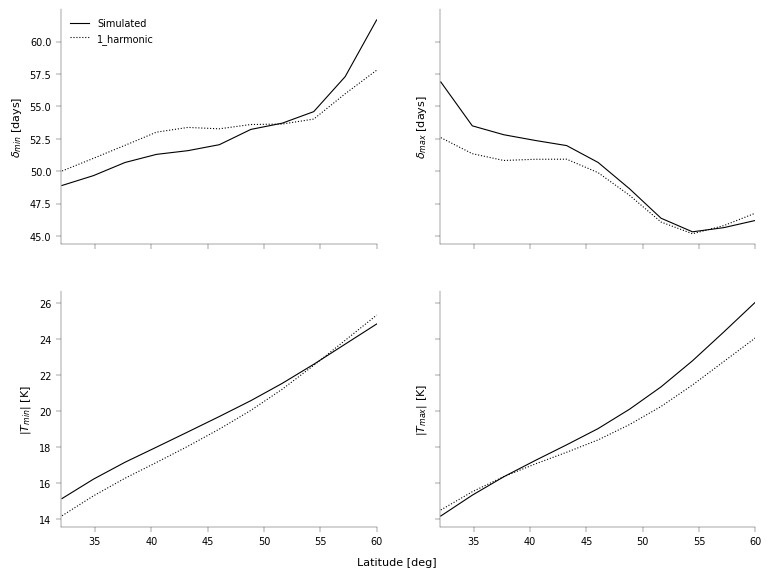

In [33]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2 if key2 != 'linear' else '2_harmonic')
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
ax[0, 0].legend()
fig

In [34]:
fig_error, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
key = '1_harmonic'
ax[0].axhline(0, color=color_approx[key], linestyle=linestyle_approx[key])
ax[1].plot(ds.lat, error_func(smooth_func(t_surf), temp_approx[key]), color=color_approx[key], 
           label=key, linestyle=linestyle_approx[key])
ax[1].legend()
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_xlim(ax_lims_lat)
fig_error.supxlabel('Latitude [deg]', fontsize=8)
plt.close()

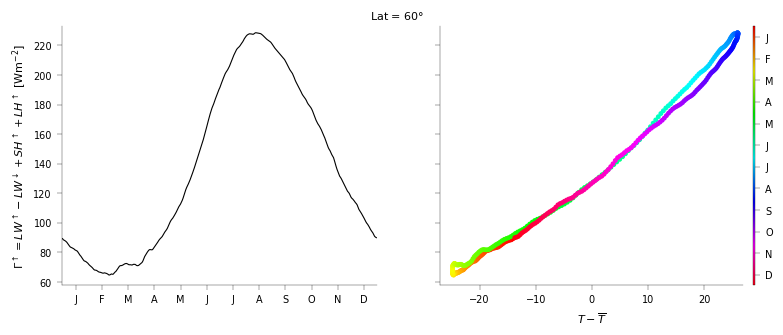

In [35]:
fig_sl_gamma, ax = plt.subplots(1,2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(gamma['simulated'][plot_lat_ind]), color='k', label='Simulated')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma['simulated'][plot_lat_ind]), c=ds.time, cmap='hsv')

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T - \overline{T}$')
ax[1].set_xlim(-np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()), np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()))
ax[1].set_ylim(np.floor(gamma['simulated'][plot_lat_ind].min()), np.ceil(gamma['simulated'][plot_lat_ind].max()))
# ax[0].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
fig_sl_gamma.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=8, y=0.93);

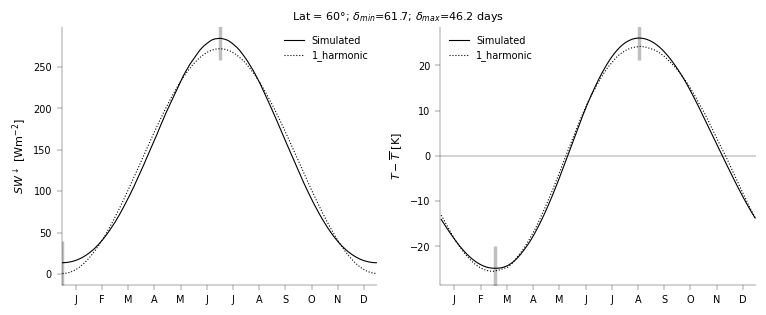

In [36]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
key = '1_harmonic'
ax[0].plot(ds.time, sw_fourier_fit[key][plot_lat_ind], color='k', linestyle=':', label=key)
ax[1].plot(ds.time, temp_approx[key][plot_lat_ind]-temp_approx[key][plot_lat_ind].mean(), color=color_approx[key],
           linestyle=linestyle_approx[key], label=key)
ax[0].legend()
ax[1].legend()
fig

## Linear Surface Budget
The surface energy budget is $C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}$

If we can represent $\Gamma^{\uparrow}(t) = (LW^{\uparrow} - LW^{\downarrow}) + LH^{\uparrow} + SH^{\uparrow} \approx \lambda_0 + \lambda T'(t)$, and keep the single harmonic approximation of $SW^{\downarrow}$, then a Fourier solution for $T'(t)$ is possible:

$T'(t) = \frac{T_0}{2} + T_1\cos(2\pi ft - \phi)$

where $T' = T-\overline{T}$ is the temperature anomaly.

Below, we look at how accurate this approximation is.

In [174]:
day_seconds=86400
def get_x_from_lambda(lambda_const, heat_capacity=heat_capacity, f=1/360, day_seconds=day_seconds):
    return 2*np.pi*f/day_seconds*heat_capacity/lambda_const


key = 'linear'
gamma_params = {key: np.zeros((n_lat, 2))}      # lowest power is last
gamma[key] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    gamma_params[key][i] = np.polyfit(t_surf_anom[i], gamma['simulated'][i], 1)
    gamma[key][i] = numerical.apply_polyfit(t_surf_anom[i], gamma_params[key][i])

temp_approx[key] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    temp_approx[key][i] = get_temp_fourier_analytic(ds.time, ds.swdn_sfc.isel(lat=i), heat_capacity, gamma_params[key][i][0], 
                                           n_harmonics_sw=1)[0]
if np.abs(temp_approx[key].mean(axis=1)).max()>1e-12:
    raise ValueError('Fourier fit should have returned anomaly but mean is non-zero')
temp_approx[key] = temp_approx[key] + t_surf.mean(axis=1)[:, np.newaxis]        # make sure has same mean as actual temperature

# Use analytical solution for 1 harmonic so as to make value a float, more accurate
time_extrema_temp['min'][key] = np.arctan(get_x_from_lambda(gamma_params[key][:, 0], heat_capacity))/(2*np.pi)*360
time_extrema_temp['max'][key] = time_extrema_temp['min'][key]+360/2
amp_extrema_temp['min'][key] = np.abs(sw_amp_coefs['1_harmonic'][:, 1]/gamma_params[key][:, 0]/np.sqrt(
    1+get_x_from_lambda(gamma_params[key][:, 0], heat_capacity)**2))
amp_extrema_temp['max'][key] = amp_extrema_temp['min'][key]

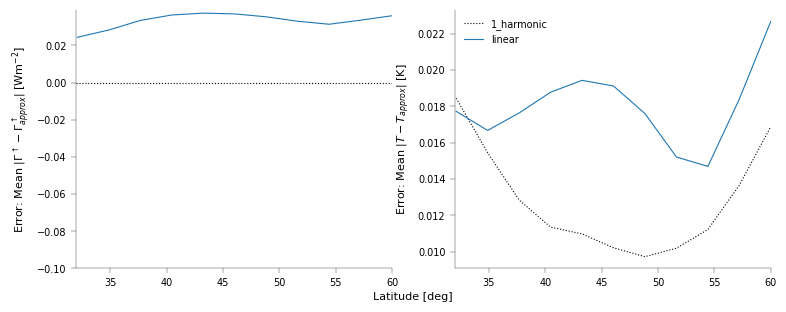

In [175]:
fig = copy.deepcopy(fig_error)
ax = np.asarray(fig.axes)
for key in ['linear']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma['simulated']), gamma[key]), color=color_approx[key],
               label=key, linestyle=linestyle_approx[key])
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf), temp_approx[key]), color=color_approx[key],
               label=key, linestyle=linestyle_approx[key])
ax[1].legend()
ax[0].set_ylim(-0.1, ax[0].get_ylim()[1])
fig

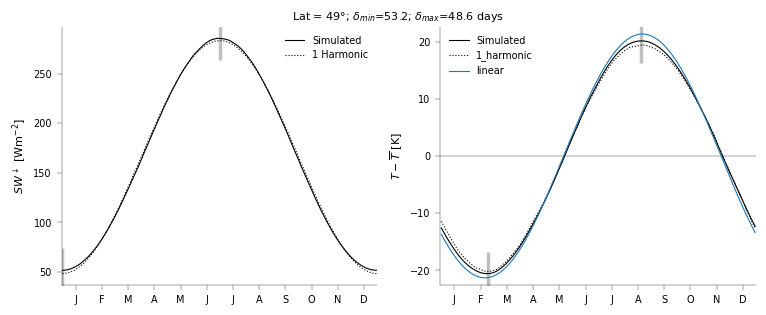

In [19]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
ax[0].plot(ds.time, sw_fourier_fit['1_harmonic'][plot_lat_ind], color='k',
           linestyle=':', label='1 Harmonic')
for key2 in ['1_harmonic', 'linear']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2],
               label=key2, linestyle=linestyle_approx[key2])

ax[0].legend()
ax[1].legend()
fig

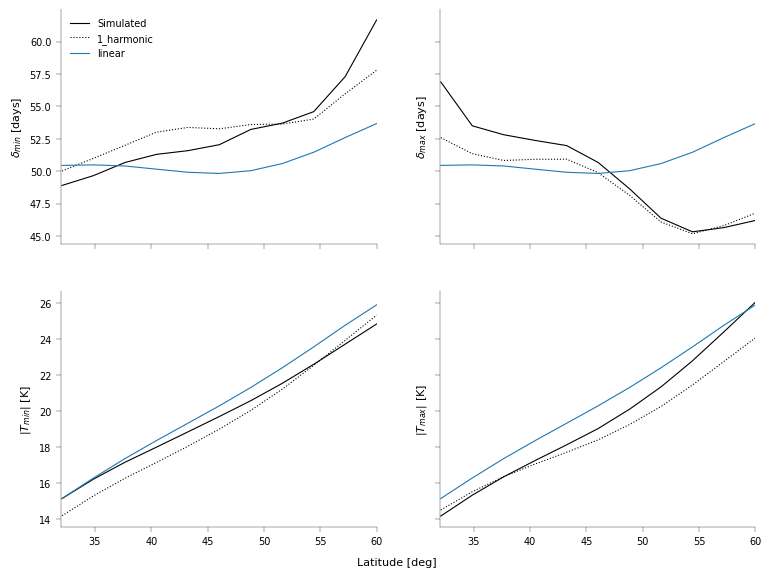

In [20]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic', 'linear']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      label=key2, linestyle=linestyle_approx[key2])
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], linestyle=linestyle_approx[key2])
    # ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_taylor_calc'] - time_extrema_sw[key], color=color_approx['linear'], marker='+',
    #                  label='2_harmonic_taylor_calc')
    # ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_taylor_calc'], color=color_approx['linear'], marker='+')
ax[0, 0].legend()
fig

## Breakdown of $\Gamma^{\uparrow}$
Above we see that the linear surface budget approximation matches the amplitude of the extrema just as well as the exact $\Gamma$ solution with 1 harmonic, but it fails to capture the latitudinal trends in phase: minima occurs later in the year as latitude increases, while maxima occurs earlier.

This suggests that we can improve our approximation for $\Gamma$ at these lower latitudes by including $T^2$ or higher power terms etc, while neglecting further harmonics. We look into this now.

We first breakdown how good the linear approximation is for each term in $\Gamma$. We do this, by keeping each term in $\Gamma$ as the exact term, except for one which we set to be the linear approximation.

There is no obvious candidate here, although it is clear that the linear approximation of sensible heat pushes the coldest day later in the year, and pulls the hottest day earlier.

In [21]:
key = 'simulated'
gamma_comp_params = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp['lw'][key] = (ds.lwup_sfc-ds.lwdn_sfc).transpose().to_numpy()
gamma_comp['lh'][key] = (ds.flux_lhe).transpose().to_numpy()
gamma_comp['sh'][key] = (ds.flux_t).transpose().to_numpy()

n_approx_params = {'linear': 2, 'square': 3, 'linear_phase': 3, 'square_phase': 4}
for key in ['linear', 'square', 'linear_phase', 'square_phase']:
    for key2 in gamma_comp:
        gamma_comp_params[key2][key] = np.zeros((n_lat, n_approx_params[key]))
        gamma_comp[key2][key] = np.zeros((n_lat, n_time))
        for i in range(n_lat):
            if 'phase' in key:
                gamma_comp_params[key2][key][i] = numerical.polyfit_with_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i], 
                                                                               n_approx_params[key.replace('_phase', '')]-1, ds.time.to_numpy())
                gamma_comp[key2][key][i] = numerical.apply_polyfit(t_surf_anom[i], gamma_comp_params[key2][key][i], ds.time.to_numpy())
            else:
                gamma_comp_params[key2][key][i] = np.polyfit(t_surf_anom[i], gamma_comp[key2]['simulated'][i], n_approx_params[key]-1)
                gamma_comp[key2][key][i] = numerical.apply_polyfit(t_surf_anom[i], gamma_comp_params[key2][key][i])
            # if key=='linear':
            # for key3 in gamma_comp:
            #     if key3 == key2:
            #         gamma[key2][i] += gamma_comp[key3][key][i]    # only use approx for one component
            #     else:
            #         gamma[key2][i] += gamma_comp[key3]['simulated'][i]

In [22]:
with (tqdm(total=n_lat*len(gamma_comp), position=0, leave=True) as pbar):
    for key in gamma_comp:
        temp_approx[key] =  np.zeros((n_lat, n_time))
        for key2 in time_extrema_temp:
                time_extrema_temp[key2][key] = np.zeros(n_lat)
                amp_extrema_temp[key2][key] = np.zeros(n_lat)
        gamma_use = gamma_comp[key]['linear'] + np.sum([gamma_comp[key2]['simulated'] for key2 in gamma_comp if key2!=key], axis=0)
        for i in range(n_lat):
            temp_approx[key][i] = get_temp_exact(ds.time.to_numpy(), sw_fourier_fit['1_harmonic'][i], gamma_use[i], heat_capacity, t_surf[i, 0])
            for key2 in time_extrema_temp:
                var_use, spline_use = get_var_extrema_date(ds.time, temp_approx[key][i] - np.mean(temp_approx[key][i]),
                                                           smooth_window=smooth_ndays_temp_extrema, type=key2, max_extrema=1)
                time_extrema_temp[key2][key][i] = var_use[0]
                amp_extrema_temp[key2][key][i] = np.abs(spline_use(time_extrema_temp[key2][key][i]))
            # Ensure have the same mean value as actual temperature
            temp_approx[key] = temp_approx[key]-temp_approx[key].mean(axis=1)[:, np.newaxis] + t_surf.mean(axis=1)[:, np.newaxis]
            pbar.update(1)

100%|██████████| 33/33 [00:00<00:00, 303.87it/s]


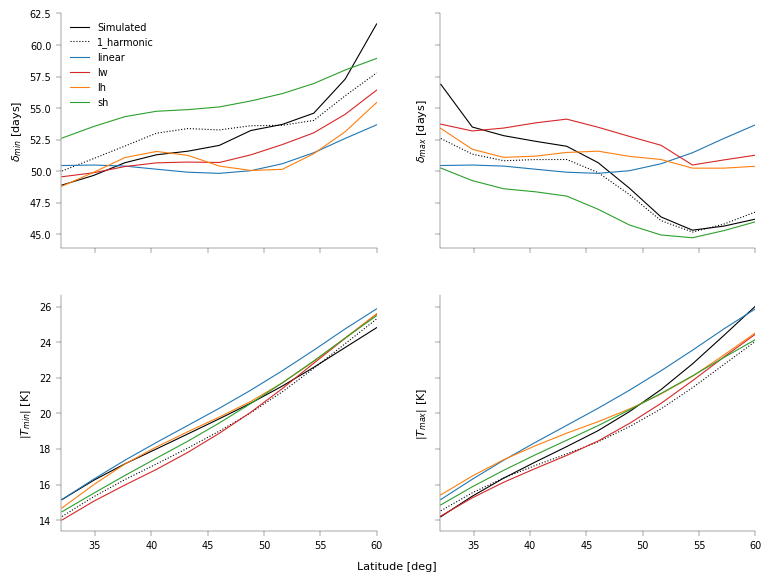

In [23]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic', 'linear', 'lw', 'lh', 'sh']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2],
                      label=key2, linestyle=linestyle_approx[key2] if key2=='1_harmonic' else None)
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2] if key2=='1_harmonic' else None)
ax[0, 0].legend()
fig

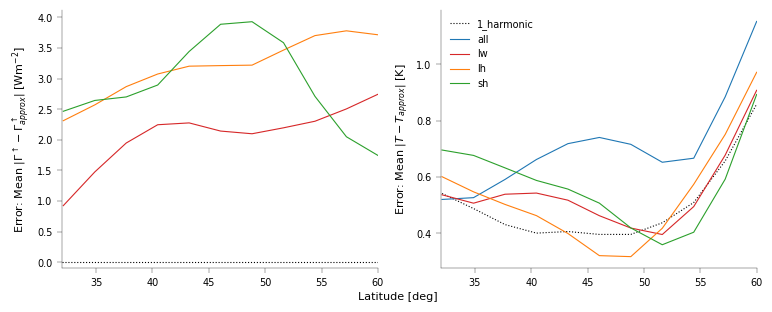

In [24]:
fig_comp_error = copy.deepcopy(fig_error)
ax = np.asarray(fig_comp_error.axes)
ax[1].plot(ds.lat, error_func(smooth_func(t_surf), temp_approx['linear']), color=color_approx['linear'],
               label='all')
for key in ['lw', 'lh', 'sh']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma_comp[key]['simulated']), gamma_comp[key]['linear']), color=color_approx[key],
               label='linear' if key=='lw' else None)
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf), temp_approx[key]), color=color_approx[key],
               label=key)
ax[1].legend()
ax[0].set_ylim(-0.1, ax[0].get_ylim()[1])
fig_comp_error

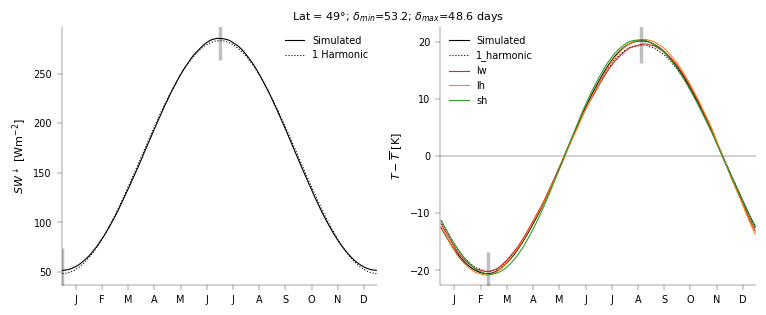

In [25]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
ax[0].plot(ds.time, sw_fourier_fit['1_harmonic'][plot_lat_ind], color='k',
           linestyle=linestyle_approx['1_harmonic'], label='1 Harmonic')
for key2 in ['1_harmonic', 'lw', 'lh', 'sh']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2],
               label=key2, linestyle=linestyle_approx[key2] if key2=='1_harmonic' else None)

ax[0].legend()
ax[1].legend()
fig

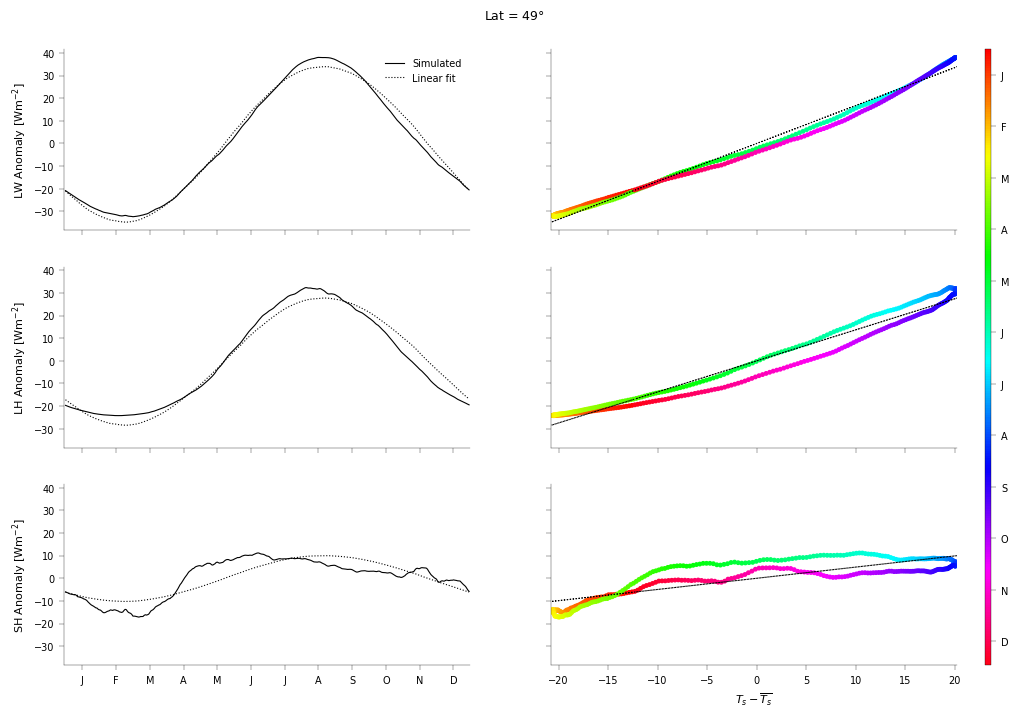

In [26]:
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey=True, sharex='col')
for i, key in enumerate(gamma_comp):
    ax[i, 0].plot(ds.time, smooth_func(gamma_comp[key]['simulated'][plot_lat_ind]-
                                       gamma_comp[key]['simulated'][plot_lat_ind].mean()), color='k', label='Simulated')
    im = ax[i, 1].scatter(smooth_func(t_surf_anom[plot_lat_ind]),
                          smooth_func(gamma_comp[key]['simulated'][plot_lat_ind]-gamma_comp[key]['simulated'][plot_lat_ind].mean()),
                          c=ds.time, cmap='hsv')
    ax[i, 0].plot(ds.time, gamma_comp[key]['linear'][plot_lat_ind]-gamma_comp[key]['linear'][plot_lat_ind].mean(),
                  color='k', linestyle=':', label='Linear fit')
    ax[i, 1].plot(t_surf_anom[plot_lat_ind], gamma_comp[key]['linear'][plot_lat_ind]-gamma_comp[key]['linear'][plot_lat_ind].mean(),
                  color='k', linestyle=':')
    ax[i, 0].set_ylabel(key.upper() + ' Anomaly [Wm$^{-2}$]')
    # fit_param = optimize.curve_fit(square_func, t_surf_anom[no_conv_time_ind], var[no_conv_time_ind], [80, 3, 0])[0]
    # ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='g', linestyle='--', label='Square fit (non convecting)')
    # ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='g', linestyle='--')
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom[plot_lat_ind].min(), t_surf_anom[plot_lat_ind].max())
ax[0, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Beyond Linear Fit
Above we see that there is a clear need to include $T^2$ and phase shift terms in the approximation for $\Gamma$ components, latent heat in particular.

Below, we look at the effect of approximating each $\Gamma$ component as:

$\Gamma(t) \approx \lambda_0 + \lambda T'(t) + \lambda_{sq} T'(t)^2 + \lambda_{phase}T(t-90)$

Clearly the phase factor is important at low latitudes, and the square factor at high latitudes.

In [27]:
for key in ['square', 'linear_phase', 'square_phase']:
    for key2 in time_extrema_temp:
        time_extrema_temp[key2][key] = np.zeros(n_lat)
        amp_extrema_temp[key2][key] = np.zeros(n_lat)
    temp_approx[key] = np.zeros((n_lat, n_time))
    gamma_params[key] = np.zeros((n_lat, 4))
    gamma[key] = np.zeros((n_lat, n_time))
    for i in range(1, 3):
        gamma_params[key][:, -i] = gamma_comp_params['lw'][key][:, -i]+gamma_comp_params['lh'][key][:, -i]+gamma_comp_params['sh'][key][:, -i]
    if 'phase' in key:
        gamma_params[key][:, 0] = gamma_comp_params['lw'][key][:, 0]+gamma_comp_params['lh'][key][:, 0]+gamma_comp_params['sh'][key][:, 0]
    if 'square' in key:
        gamma_params[key][:, 1] = gamma_comp_params['lw'][key][:, -3]+gamma_comp_params['lh'][key][:, -3]+gamma_comp_params['sh'][key][:, -3]
    for i in range(n_lat):
        gamma[key][i] = numerical.apply_polyfit(t_surf_anom[i], gamma_params[key][i], ds.time.to_numpy())
        temp_approx[key][i] = get_temp_fourier_analytic(ds.time, ds.swdn_sfc.isel(lat=i), heat_capacity, gamma_params[key][i, -2], 
                                                        gamma_params[key][i, 0], gamma_params[key][i, 1], n_harmonics_sw=1, 
                                                        n_harmonics_temp=2 if 'square' in key else 1)[0]
        for key2 in time_extrema_temp:
            var_use, spline_use = get_var_extrema_date(ds.time, temp_approx[key][i] - np.mean(temp_approx[key][i]),
                                                       smooth_window=smooth_ndays_temp_extrema, type=key2, max_extrema=1)
            time_extrema_temp[key2][key][i] = var_use[0]
            amp_extrema_temp[key2][key][i] = np.abs(spline_use(time_extrema_temp[key2][key][i]))
    if np.abs(temp_approx[key].mean(axis=1)).max()>1e-12:
        raise ValueError('Fourier fit should have returned anomaly but mean is non-zero')
    temp_approx[key] = temp_approx[key] + t_surf.mean(axis=1)[:, np.newaxis]        # make sure has same mean as actual temperature

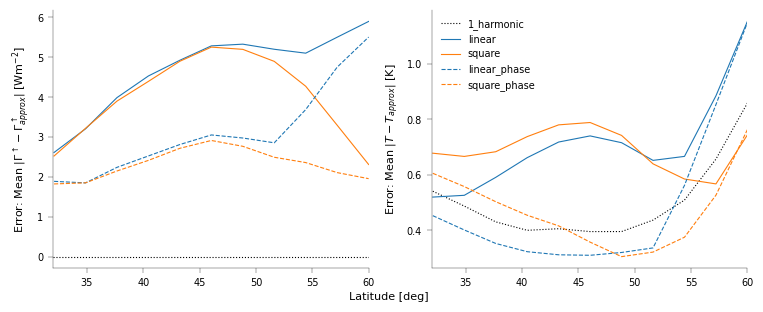

In [28]:
fig = copy.deepcopy(fig_error)
ax = np.asarray(fig.axes)
for key2 in ['linear', 'square', 'linear_phase', 'square_phase']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma['simulated']), gamma[key2]), color=color_approx[key2],
               linestyle=linestyle_approx2[key2])
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf), temp_approx[key2]), color=color_approx[key2],
               label=key2, linestyle=linestyle_approx2[key2])
ax[1].legend()
fig

#### Influence to Extrema
Below we see that the phase term has the same effect on both extrema - shifting it later in the year and reducing amplitude. The amplitude effect of this seems most obvoously beneficial.

The square term allows for a different effect for each extrema: it shifts minima later and increases the amplitude but shifts maxima earlier and decreases the amplitude.

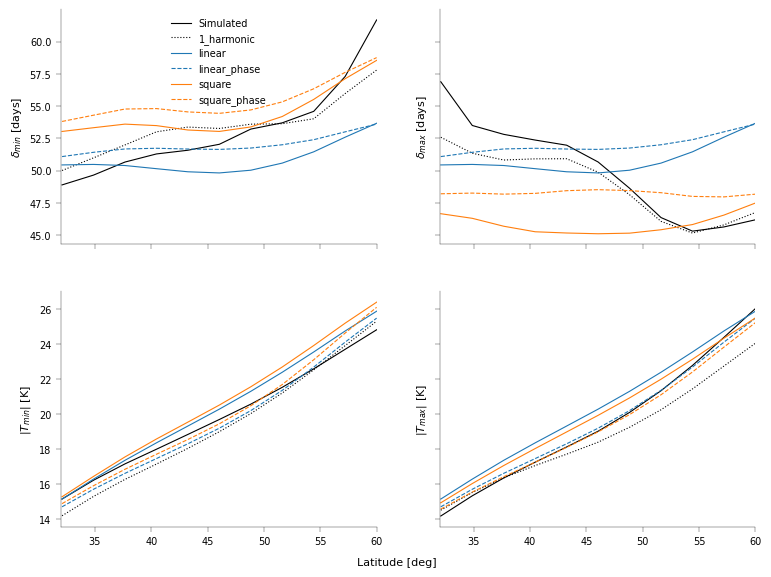

In [29]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic', 'linear', 'linear_phase', 'square', 'square_phase']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], 
                      color=color_approx[key2],
                      label=key2, linestyle=linestyle_approx2[key2])
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2] if key2 in color_approx else color_approx['linear'], 
                      linestyle=linestyle_approx2[key2])
ax[0, 0].legend()
fig

#### Single Latitude
Below we look at this for a single latitude, where the hysteresis in $\Gamma$ is clearly captured much better now.

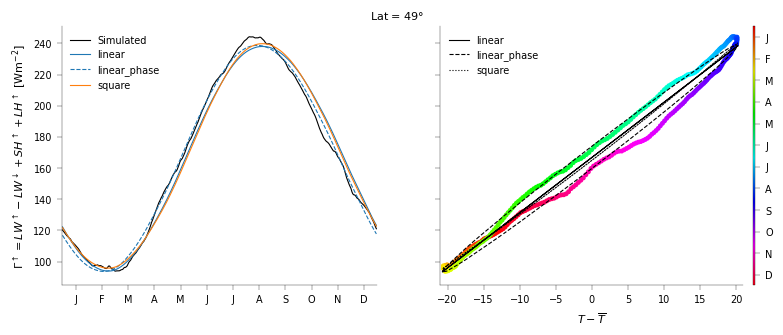

In [30]:
fig = copy.deepcopy(fig_sl_gamma)
ax = np.asarray(fig.axes)
for key in ['linear', 'linear_phase', 'square']:
    ax[0].plot(ds.time, smooth_func(gamma[key][plot_lat_ind]), color=color_approx[key], linestyle=linestyle_approx2[key], label=key)
    ax[1].plot(t_surf_anom[plot_lat_ind], gamma[key][plot_lat_ind], color='k', linestyle=linestyle_approx[key], label=key)
ax[0].legend()
ax[1].legend()
fig

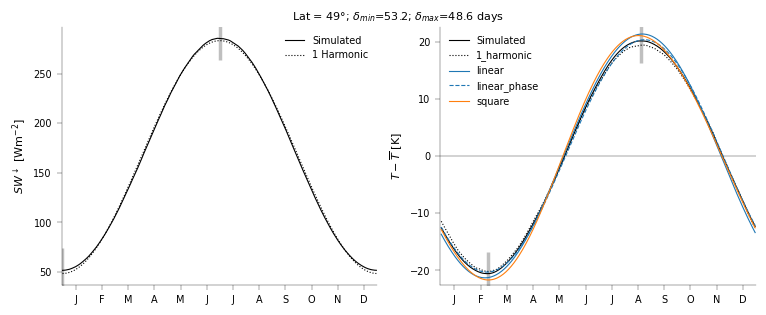

In [31]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
ax[0].plot(ds.time, sw_fourier_fit['1_harmonic'][plot_lat_ind], color='k',
           linestyle=linestyle_approx['1_harmonic'], label='1 Harmonic')
for key2 in ['1_harmonic', 'linear', 'linear_phase', 'square']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), 
               color=color_approx[key2], 
               label=key2, linestyle=linestyle_approx2[key2])
ax[0].legend()
ax[1].legend()
fig

#### Explicit effect of $\lambda_{phase}$ and $\lambda_{sq}$

In [32]:
for key in ['square_0', 'linear_phase_0']:
    for key2 in time_extrema_temp:
        time_extrema_temp[key2][key] = np.zeros(n_lat)
        amp_extrema_temp[key2][key] = np.zeros(n_lat)
    temp_approx[key] = np.zeros((n_lat, n_time))
    for i in range(n_lat):
        temp_approx[key][i] = get_temp_fourier_analytic(ds.time, ds.swdn_sfc.isel(lat=i), heat_capacity, gamma_params[key.replace('_0', '')][i, -2], 
                                                        n_harmonics_sw=1)[0]
        for key2 in time_extrema_temp:
            var_use, spline_use = get_var_extrema_date(ds.time, temp_approx[key][i] - np.mean(temp_approx[key][i]),
                                                       smooth_window=smooth_ndays_temp_extrema, type=key2, max_extrema=1)
            time_extrema_temp[key2][key][i] = var_use[0]
            amp_extrema_temp[key2][key][i] = np.abs(spline_use(time_extrema_temp[key2][key][i]))
    if np.abs(temp_approx[key].mean(axis=1)).max()>1e-12:
        raise ValueError('Fourier fit should have returned anomaly but mean is non-zero')
    temp_approx[key] = temp_approx[key] + t_surf.mean(axis=1)[:, np.newaxis]        # make sure has same mean as actual temperature

In [63]:
# Sanity check that spline integeral gives same result as analytic solution
for key in ['linear_spline']:
    temp_approx[key] = np.zeros((n_lat, n_time))
    for i in range(n_lat):
        temp_approx[key][i] = get_temp_exact(ds.time.to_numpy(), sw_fourier_fit['1_harmonic'][i], gamma[key.replace('_spline', '')][i], 
                                             heat_capacity, t_surf[i, 0], seek_fourier=True, lambda_const_guess=gamma_params['linear'][i, 0], n_harmonics=1)
    temp_approx[key] = temp_approx[key] - temp_approx[key].mean(axis=1)[:, np.newaxis] + t_surf.mean(axis=1)[:, np.newaxis] # make sure has actual mean

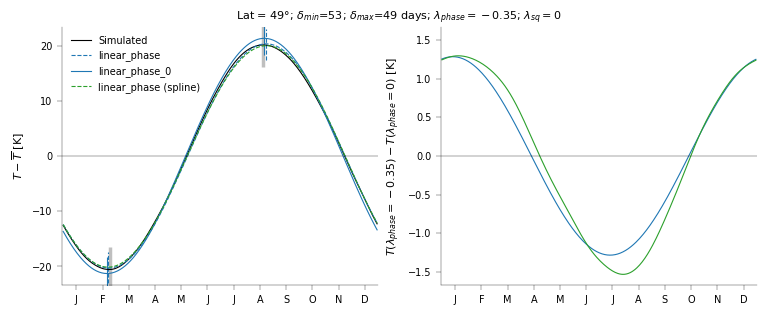

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
show_sanity_check=True
ax[0].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for approx_plot in ['linear_phase', 'square'][:1]:
    for key2 in [approx_plot, approx_plot+'_0']:
        ax[0].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[approx_plot], 
                              linestyle=linestyle_approx[key2], label=key2)
    ax[1].plot(ds.time, (temp_approx[approx_plot][plot_lat_ind]-temp_approx[approx_plot][plot_lat_ind].mean()) -
               (temp_approx[approx_plot+'_0'][plot_lat_ind]-temp_approx[approx_plot+'_0'][plot_lat_ind].mean()),
               color=color_approx[approx_plot])
    for key in time_extrema_sw:
        ax[0].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                           color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
        for key2 in [approx_plot, approx_plot+'_0']:
            ax[0].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                               color=color_approx[approx_plot], marker='|', s=500, 
                          linestyle=linestyle_approx[key2])
    if show_sanity_check:
        ax[0].plot(ds.time, temp_approx[approx_plot+'_spline'][plot_lat_ind]-temp_approx[approx_plot+'_spline'][plot_lat_ind].mean(),
                   color=default_colors[2], label='linear_phase (spline)', linestyle=linestyle_approx[approx_plot])
        ax[1].plot(ds.time, (temp_approx[approx_plot+'_spline'][plot_lat_ind]-temp_approx[approx_plot+'_spline'][plot_lat_ind].mean()) -
               (temp_approx[approx_plot+'_0'][plot_lat_ind]-temp_approx[approx_plot+'_0'][plot_lat_ind].mean()),
               color=default_colors[2])

ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
ax[1].set_ylabel(f'$T(\lambda_{"{phase}"}={gamma_params["linear_phase"][plot_lat_ind, 0]:.2g}) - T(\lambda_{"{phase}"}= 0)$ [K]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$; "
             f"$\delta_{'{min}'}$={time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min']:.0f}; "
             f"$\delta_{'{max}'}$={time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max']:.0f} days; "
             f"$\lambda_{'{phase}'}={gamma_params[approx_plot][plot_lat_ind, 0]:.2g}$; "
             f"$\lambda_{'{sq}'}={gamma_params[approx_plot][plot_lat_ind, 1]:.2g}$", fontsize=8, y=0.93);

Text(0.5, 0.01, 'Latitude [deg]')

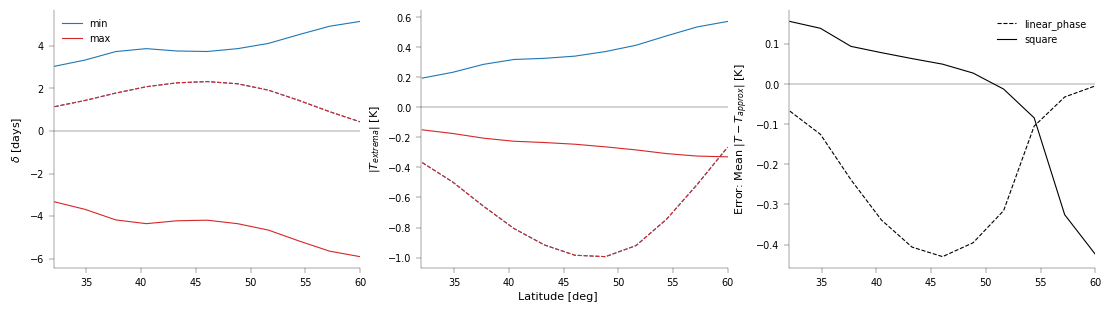

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(im_sz*3*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for key2 in ['linear_phase', 'square']:
    for i, key in enumerate(time_extrema_temp):
        ax[0].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_temp[key][key2+'_0'], 
                   color=color_extrema[key], label=key if 'linear' not in key2 else None, linestyle=linestyle_approx2[key2])
        ax[1].plot(ds.lat, amp_extrema_temp[key][key2] - amp_extrema_temp[key][key2+'_0'], 
                   color=color_extrema[key], label=f"{'Approx' if 'approx' in key2 else 'Full'} Fourier" if key=='min' else None,
                   linestyle=linestyle_approx2[key2])
    ax[2].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_approx[key2] - 
                              np.mean(temp_approx[key2], axis=1)[:, np.newaxis]) - 
               error_func(smooth_func(t_surf_anom), temp_approx[key2+'_0'] - 
                              np.mean(temp_approx[key2+'_0'], axis=1)[:, np.newaxis]), color='k', 
               linestyle=linestyle_approx2[key2], label=key2)
    # ax[0].scatter(ds.lat, time_extrema_temp[key]['linear_shift_taylor_calc'] - time_extrema_temp[key]['linear_shift_0_taylor_calc'], 
    #                color=color_extrema[key], marker='+')
    # ax[1].scatter(ds.lat, amp_extrema_temp[key]['linear_shift_taylor_calc'] - amp_extrema_temp[key]['linear_shift_0_taylor_calc'], 
    #                color=color_extrema[key], label='Taylor Calc' if key=='min' else None, marker='+')
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ax_lims_lat)
ax[0].legend()
ax[2].legend()
ax[0].set_ylabel('$\delta$ [days]')
ax[1].set_ylabel('$|T_{extrema}|$ [K]')
ax[2].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
# ax[0].set_ylim(-2, 8)
fig.supxlabel('Latitude [deg]', fontsize=8)
# fig.suptitle('Ex\lambda_{phase}) - T(\lambda_{phase}=0)$ Difference', fontsize=8);

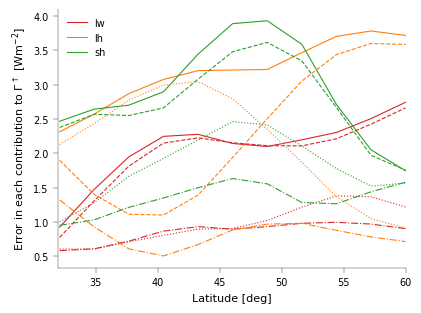

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for key in ['lw', 'lh', 'sh']:
    ax.plot(ds.lat, error_func(smooth_func(gamma_comp[key]['simulated']), gamma_comp[key]['linear']), color=color_approx[key],
               label=key)
for key2 in ['square', 'linear_phase', 'square_phase']:
    for key in ['lw', 'lh', 'sh']:
        ax.plot(ds.lat, error_func(smooth_func(gamma_comp[key]['simulated']), gamma_comp[key][key2]), color=color_approx[key], 
                linestyle=linestyle_approx[key2])
ax.legend()
ax.set_ylabel('Error in each contribution to $\Gamma^{\\uparrow}$ [Wm$^{-2}$]')
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]');

## Latent Heat

The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L598) used for latent heat flux by Isca is: $LH = f_{evap}L_v C_q\rho |v|(q^*(T_s, p_s) - q_{a})$

where $f_{evap}=0.1$ is the evaporative prefactor for this experiment.

So given that $q_a = r_aq^*(T_a, p_a)$; $\rho = p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, latent heat is only a function of 6 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Relative humidity, $r_a$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

In [43]:
def get_latent_heat(temp_surf, temp_diseqb, rh, wind_speed, drag_coef, p_surf, sigma=sigma_near_surf, evap_prefactor=evap_prefactor):
    temp_a = temp_surf - temp_diseqb
    p_a = p_surf*sigma
    rho = get_density(temp_a, p_a)
    sphum_a = rh * sphum_sat(temp_a, p_a)
    return evap_prefactor * L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

In [44]:
ds_mean = ds.mean(dim='time')
lh_manual = {'all_cont': get_annual_zonal_mean(get_latent_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].rh,
                                                               ds_base[0].w_atm, ds_base[0].drag_q, ds_base[0].ps)),
             'all_cont_av_first': get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh, ds.w_atm, ds.drag_q, ds.ps),
             'mean': get_latent_heat(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.rh, ds_mean.w_atm,
                                       ds_mean.drag_q, ds_mean.ps)}

alpha_s = clausius_clapeyron_factor(ds_mean.t_surf, ds_mean.ps)
q_sat_s = sphum_sat(ds_mean.t_surf, ds_mean.ps)
alpha_a = clausius_clapeyron_factor(ds_mean.temp, sigma_near_surf*ds_mean.ps)
q_sat_a = sphum_sat(ds_mean.temp, sigma_near_surf*ds_mean.ps)
ds_mean['rho_calc'] = get_density(ds_mean.temp, sigma_near_surf*ds_mean.ps)
lh_prefactor = evap_prefactor*L_v*ds_mean.drag_q*ds_mean.w_atm*ds_mean.rho_calc

lh_taylor = {'t_surf': -lh_manual['mean']/ds_mean['temp'] + lh_prefactor*(alpha_s*q_sat_s-ds_mean.rh*alpha_a*q_sat_a),
             'temp_diseqb': lh_manual['mean']/ds_mean['temp'] + lh_prefactor*ds_mean.rh*alpha_a*q_sat_a,
             'rh': -lh_prefactor*q_sat_a}
for key in ['w_atm', 'drag_q', 'ps']:
    lh_taylor[key] = lh_manual['mean']/ds_mean[key]
lh_taylor['sum'] = 0
for key in lh_taylor:
    if key=='sum':
        continue
    lh_taylor['sum'] += (lh_taylor[key]*(ds[key]-ds_mean[key]))
lh_taylor['sum'] = lh_taylor['sum'] + lh_manual['mean']
lh_taylor['t_surf_square'] = -lh_taylor['t_surf']/ds_mean.temp + lh_manual['mean']/ds_mean.temp**2+lh_prefactor*(
    alpha_s*q_sat_s/ds_mean.t_surf * (alpha_s*ds_mean.t_surf-2) - ds_mean.rh*alpha_a*q_sat_a/ds_mean.temp * (alpha_a*ds_mean.temp-2)
)
lh_taylor['t_surf_square']  = lh_taylor['t_surf_square']*0.5
lh_taylor['t_surf_w_atm'] = lh_taylor['t_surf']/ds_mean.w_atm
lh_taylor['t_surf_rh'] = -lh_prefactor * alpha_a*q_sat_a

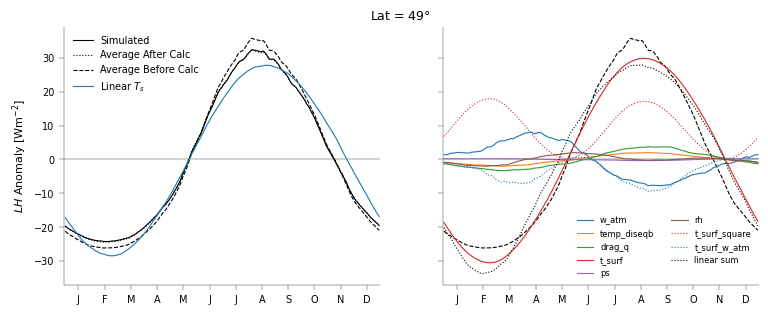

In [45]:
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)

ax[0].plot(ds.time, smooth_func(ds.flux_lhe.isel(lat=plot_lat_ind)-ds.flux_lhe.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(lh_manual['all_cont'].isel(lat=plot_lat_ind)-lh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
for i in range(len(ax)):
    ax[i].plot(ds.time, smooth_func(lh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                                    lh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--',
            label='Average Before Calc' if i==0 else None)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].plot(ds.time, gamma_comp['lh']['linear'][plot_lat_ind]-gamma_comp['lh']['linear'][plot_lat_ind].mean(), color=default_colors[0],
           label='Linear $T_s$')

for i, key in enumerate(['w_atm', 'temp_diseqb', 'drag_q', 't_surf', 'ps', 'rh']):
    ax[1].plot(ds.time, smooth_func((lh_taylor[key]*(ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), label=key, color=default_colors[i])
ax[1].plot(ds.time, smooth_func((lh_taylor['t_surf_square']*(ds['t_surf']-ds_mean['t_surf'])**2).isel(lat=plot_lat_ind)),
           label='t_surf_square', color=default_colors[3], linestyle=':')
if is_wishe:
    ax[1].plot(ds.time,
               smooth_func((lh_taylor['t_surf_w_atm']*(ds['t_surf']-ds_mean['t_surf'])*(ds['w_atm']-ds_mean['w_atm'])).isel(lat=plot_lat_ind)),
               label='t_surf_w_atm', color=default_colors[0], linestyle=':')
else:
    ax[1].plot(ds.time,
               smooth_func((lh_taylor['t_surf_rh']*(ds['t_surf']-ds_mean['t_surf'])*(ds['rh']-ds_mean['rh'])).isel(lat=plot_lat_ind)),
               label='t_surf_rh', color=default_colors[5], linestyle=':')
ax[1].plot(ds.time, smooth_func(lh_taylor['sum'].isel(lat=plot_lat_ind)-lh_taylor['sum'].isel(lat=plot_lat_ind).mean()), color='k', linestyle=':', label='linear sum')
ax[0].legend()
ax[1].legend(ncol=2, fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$LH$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

## Sensible Heat
The most obvious result from the above analysis is that the linear approximation of sensible heat changes the phasing in quite a systematic way. We now investigate why that is the case.

The equation for sensible heat is: $SH = c_p C_t\rho |v|\bigg(T_s - T_a\big(\frac{p_s}{p_a}\big)^{\kappa}\bigg)$

So given that $\rho = p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, sensible heat is only a function of 5 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

Below we investigate the relative contribution of each of these factors. We clearly see that non-linear terms are important in the taylor series, and we have no hope of getting an expression for $SH$ in terms of just $T_s$.

In [46]:
def get_sensible_heat(temp_surf, temp_diseqb, wind_speed, drag_coef, p_surf=None, density=None, sigma=sigma_near_surf):
    temp_a = temp_surf - temp_diseqb
    if density is None:
        if p_surf is None:
            raise ValueError('If density not given; surface pressure required')
        p_a = p_surf*sigma
        density = get_density(temp_a, p_a)
    return c_p * drag_coef * density * wind_speed * (temp_surf - temp_a * (1/sigma)**kappa)

In [47]:
sh_manual = {'all_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].w_atm,
                                                                 ds_base[0].drag_q, ds_base[0].ps)),
             'all_cont_const_density': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].w_atm,
                                                                 ds_base[0].drag_q, density=ds.rho.mean(dim='time'))),
             'all_cont_av_first': get_sensible_heat(ds.t_surf, ds.temp_diseqb, ds.w_atm, ds.drag_q, ds.ps),
             'all_cont_av_first_const_density': get_sensible_heat(ds.t_surf, ds.temp_diseqb, ds.w_atm, ds.drag_q, density=ds.rho.mean(dim='time')),
             'mean': get_sensible_heat(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.w_atm,
                                       ds_mean.drag_q, ds_mean.ps),
             't_surf_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb.mean(dim='time'),
                                                                    ds_base[0].w_atm.mean(dim='time'), ds_base[0].drag_q.mean(dim='time'),
                                                                    ds_base[0].ps.mean(dim='time'))),
             'temp_diseqb_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb,
                                                                         ds_base[0].w_atm.mean(dim='time'),
                                                                         ds_base[0].drag_q.mean(dim='time'), ds_base[0].ps.mean(dim='time'))),
             'pressure_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb.mean(dim='time'),
                                                   ds_base[0].w_atm.mean(dim='time'), ds_base[0].drag_q.mean(dim='time'), ds_base[0].ps)),
             'wind_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb.mean(dim='time'),
                                                ds_base[0].w_atm, ds_base[0].drag_q.mean(dim='time'), ds_base[0].ps.mean(dim='time'))),
             'drag_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb.mean(dim='time'),
                                                   ds_base[0].w_atm.mean(dim='time'),
                                                   ds_base[0].drag_q, ds_base[0].ps.mean(dim='time')))
             }
for key in sh_manual:
    if ('cont' in key) and ('all' not in key):
        sh_manual[key] -= sh_manual['mean']

In [48]:
sh_taylor = {'t_surf': c_p*ds_mean.drag_q*ds_mean.w_atm*get_density(ds_mean.temp, sigma_near_surf*ds_mean.ps)*(
    1 - sigma_near_surf**kappa - (1/ds_mean.temp)*(ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp)),
             'temp_diseqb': c_p*ds_mean.drag_q*ds_mean.w_atm*get_density(ds_mean.temp, sigma_near_surf*ds_mean.ps)*(
    sigma_near_surf**kappa + (1/ds_mean.temp)*(ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp))}
for key in ['w_atm', 'drag_q', 'ps']:
    sh_taylor[key] = sh_manual['mean']/ds_mean[key]
sh_taylor['sum'] = 0
for key in ['w_atm', 'drag_q', 'ps', 't_surf', 'temp_diseqb']:
    sh_taylor['sum'] += (sh_taylor[key]*(ds[key]-ds_mean[key]))

gamma_comp_params['sh']['quartic'] = np.zeros((n_lat, 5))
gamma_comp['sh']['quartic'] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    gamma_comp_params['sh']['quartic'][i] = \
        scipy.optimize.curve_fit(func_approx['quartic'],
                                 ds.t_surf.isel(lat=i).to_numpy()-float(ds_mean.t_surf.isel(lat=i)),
                                 ds.flux_t.isel(lat=i).to_numpy())[0]
    gamma_comp['sh']['quartic'][i] = func_approx['quartic'](ds.t_surf.isel(lat=i).to_numpy()-float(ds_mean.t_surf.isel(lat=i)),
                                                            *gamma_comp_params['sh']['quartic'][i])

NameError: name 'func_approx' is not defined

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(ds.time, smooth_func(ds.flux_t.isel(lat=plot_lat_ind)-ds.flux_t.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(sh_manual['all_cont'].isel(lat=plot_lat_ind)-sh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
ax[0].plot(ds.time, smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                             sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--',
        label='Average Before Calc')
ax[0].plot(ds.time, gamma_comp['sh']['linear'][plot_lat_ind]-gamma_comp['sh']['linear'][plot_lat_ind].mean(), color=default_colors[0],
           label='Linear $T_s$')
ax[0].plot(ds.time, gamma_comp['sh']['quartic'][plot_lat_ind]-gamma_comp['sh']['quartic'][plot_lat_ind].mean(), color=default_colors[0],
           label='Quartic $T_s$', linestyle=':')
ax[0].plot(ds.time, smooth_func(sh_taylor['sum'].isel(lat=plot_lat_ind)), color='r', label='Linear Taylor Series')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()

ax[1].plot(ds.time, smooth_func(ds.flux_t.isel(lat=plot_lat_ind)-ds.flux_t.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')
for key in ['w_atm', 'temp_diseqb', 'drag_q', 't_surf', 'ps']:
    ax[1].plot(ds.time, smooth_func((sh_taylor[key]*(ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), label=key)
ax[1].plot(ds.time, smooth_func(sh_taylor['sum'].isel(lat=plot_lat_ind)), color='k', linestyle=':', label='Sum')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend()

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$SH$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar))
# ax.plot(smooth_func(ds.t_surf.isel(lat=plot_lat_ind)-ds_mean.t_surf.isel(lat=plot_lat_ind)),
#         smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()
#                     -(sh_taylor['w_atm']*(ds['w_atm']-ds_mean['w_atm'])).isel(lat=plot_lat_ind)))
ax.plot(smooth_func(ds.t_surf.isel(lat=plot_lat_ind)-ds_mean.t_surf.isel(lat=plot_lat_ind)),
        smooth_func(ds.w_atm.isel(lat=plot_lat_ind)), color='k', label='Simulated')

### Longwave
Looks at emissivity stuff

In [ ]:
emiss_factor = ((ds.lwdn_sfc/Stefan_Boltzmann)**0.25/ds.t_surf).transpose().to_numpy()
emiss_factor_params = {'linear': np.zeros((n_lat, 2)), 'quartic': np.zeros((n_lat, 5))}
emiss_factor_approx = {key: np.zeros((n_lat, n_time)) for key in ['linear', 'quartic']}
for i in range(n_lat):
    emiss_factor_params['linear'][i] = optimize.curve_fit(linear_func, t_surf_anom[i], emiss_factor[i])[0]
    emiss_factor_params['quartic'][i] = optimize.curve_fit(quartic_func, t_surf_anom[i], emiss_factor[i])[0]
    emiss_factor_approx['linear'][i] = linear_func(t_surf_anom[i], *emiss_factor_params['linear'][i])
    emiss_factor_approx['quartic'][i] = quartic_func(t_surf_anom[i], *emiss_factor_params['quartic'][i])

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(2*1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(emiss_factor[plot_lat_ind]), color='k')
for key in ['linear', 'quartic']:
    ax[0].plot(ds.time, emiss_factor_approx[key][plot_lat_ind], color=color_approx[key], label=key, linestyle=':')
# ax[0].plot(ds.time, emiss_factor_approx['quartic'][plot_lat_ind], color=default_colors[0], linestyle=linestyles_approx['linear_shift'], 
#            label=f"linear shift; $\Lambda = {round(emiss_factor_params['linear_shift'][-1], 1)}$ days")
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(emiss_factor[plot_lat_ind]), c=ds.time, cmap='hsv')
ax[1].plot(t_surf_anom[plot_lat_ind], emiss_factor_approx['linear'][plot_lat_ind], color=color_approx['linear'], linestyle=':')
# ax[1].plot(t_surf_anom, emiss_factor_approx['linear_shift'][plot_lat_ind], color='k', linestyle=linestyles_approx['linear_shift'])
ax[0].set_xlim(-1, 360)
ax[0].legend()
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Emission factor, $\epsilon$')
ax[1].set_xlabel('$T_s - \overline{T_s}$')
fig.suptitle(f'Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$', fontsize=9, y=0.93);

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True)
for key in emiss_factor_approx:
    ax.plot(ds.lat, error_func(smooth_func(emiss_factor), emiss_factor_approx[key]), color=color_approx[key], label=key)
ax.set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\epsilon - \epsilon_{approx}|$')
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]');